In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras import layers

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from keras_tuner import RandomSearch

np.set_printoptions(precision = 3, suppress = True)

In [2]:
sim_data = pd.read_csv("sim_data_put.csv")
df = sim_data.drop(['Unnamed: 0'], axis = 1)
df.head()

,Stock price,Strike price,Maturity,Dividend rate,Risk free rate,Volatility,Put Price
0,455.03,454.0,0.976,0.020148,0.019092,0.880006,149.640109
1,182.35,190.0,1.316,0.005972,0.019851,0.555565,47.873816
2,154.09,152.0,0.092,0.001171,0.012583,0.647748,10.877786
3,373.74,361.0,0.300,0.027602,0.022187,0.314800,19.482193
4,465.96,469.0,2.540,0.010858,0.020669,0.742902,196.271390


In [3]:
df.describe()

,Stock price,Strike price,Maturity,Dividend rate,Risk free rate,Volatility,Put Price
count,300000.000000,300000.000000,300000.000000,3.000000e+05,300000.000000,300000.000000,3.000000e+05
mean,328.246767,328.255507,1.498248,1.502393e-02,0.020000,0.475127,6.663244e+01
std,185.843818,185.523693,0.863869,8.662222e-03,0.005771,0.245260,6.103284e+01
min,6.650000,7.000000,0.004000,1.019712e-07,0.010000,0.050000,9.198406e-42
25%,167.140000,167.000000,0.752000,7.518604e-03,0.015009,0.262613,1.898152e+01
50%,328.325000,329.000000,1.496000,1.504665e-02,0.019999,0.475230,4.743913e+01
75%,488.740000,489.000000,2.244000,2.251980e-02,0.024993,0.687537,9.768983e+01
max,681.390000,649.000000,2.996000,2.999999e-02,0.030000,0.899999,3.527430e+02


In [4]:
X = df[df.columns.values[:-1]]
y = df['Put Price']

X_train, X_test, y_train, y_test = train_test_split(X.copy(), y, test_size = 0.2, random_state = 123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((240000, 6), (60000, 6), (240000,), (60000,))

In [5]:
# Standardize the features
scalerX = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scalerX.transform(X_train), columns = X.columns.values) 
X_test = pd.DataFrame(scalerX.transform(X_test), columns = X.columns.values) 

scalery = MinMaxScaler().fit(y_train.values.reshape(-1, 1))
y_train = scalery.transform(y_train.values.reshape(-1, 1))
y_test = scalery.transform(y_test.values.reshape(-1, 1))

In [6]:
np.random.seed(123)
tf.random.set_seed(123)

In [7]:
def plot_loss(history):
    plt.figure(figsize = (8,6))
    plt.plot(history.history['loss'], label = 'loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)
    
def plot_time(time):
    print('The total training time is {} seconds.'.format(np.round(np.sum(time), 1)))
    plt.figure(figsize = (8,6))
    plt.plot(np.arange(1, len(time) + 1), time)
    plt.xlabel('Epoch')
    plt.ylabel('Time for each epoch')
    plt.grid(True)

In [8]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs = {}):
        self.times = []

    def on_epoch_begin(self, batch, logs = {}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs = {}):
        self.times.append(time.time() - self.epoch_time_start)

## Robert Culkin & Sanjiv R. Das's ANN

In [9]:
learning_rate = [1e-3, 1e-4, 1e-5]
History = []
times = []
earlyStop = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)
for lr in learning_rate:
    model = models.Sequential()
    # Input layer
    model.add(layers.Dense(units = 6))

    # first layer
    model.add(layers.Dense(units = 100, activation = "ELU"))
    model.add(layers.Dropout(0.25))

    # second layer
    model.add(layers.Dense(units = 100, activation = "ELU"))
    model.add(layers.Dropout(0.25))

    # third layer
    model.add(layers.Dense(units = 100, activation = "ELU"))
    model.add(layers.Dropout(0.25))

    # fourth layer
    model.add(layers.Dense(units = 100, activation = "ELU"))
    model.add(layers.Dropout(0.25))

    # Output layer
    model.add(layers.Dense(units = 1, activation = "exponential"))

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = lr), loss = "mean_squared_error"
    )
    
    time_callback = TimeHistory()

    history = model.fit(X_train, 
        y_train, 
        epochs = 100, 
        verbose = 0,
        callbacks = [earlyStop, time_callback],
        validation_split = 0.2)
    BSNN_train_pred = model.predict(X_train)
    BSNN_test_pred = model.predict(X_test)
    print('When the learning rate is', lr)
    print("The training R squared for Robert Culkin & Sanjiv R. Das's model is", 
          np.round(r2_score(y_train, BSNN_train_pred), 4))
    print("The testing R squared for Robert Culkin & Sanjiv R. Das's model is", 
          np.round(r2_score(y_test, BSNN_test_pred), 4))
    print('-------------------------------------------------------------------')
    History.append(history)
    times.append(time_callback.times)

When the learning rate is 0.001
The training R squared for Robert Culkin & Sanjiv R. Das's model is 0.9907
The testing R squared for Robert Culkin & Sanjiv R. Das's model is 0.9907
-------------------------------------------------------------------
When the learning rate is 0.0001
The training R squared for Robert Culkin & Sanjiv R. Das's model is 0.9978
The testing R squared for Robert Culkin & Sanjiv R. Das's model is 0.9978
-------------------------------------------------------------------
When the learning rate is 1e-05
The training R squared for Robert Culkin & Sanjiv R. Das's model is 0.9529
The testing R squared for Robert Culkin & Sanjiv R. Das's model is 0.9531
-------------------------------------------------------------------


### With learning rate 1e-3

The total training time is 261.1 seconds.


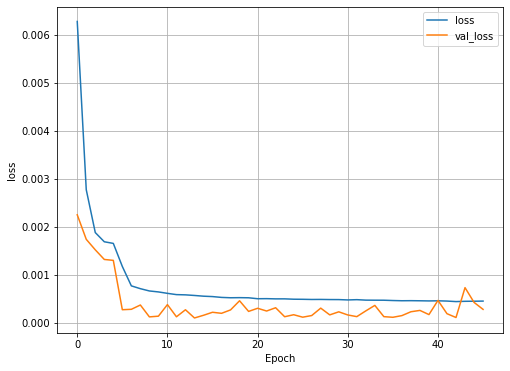

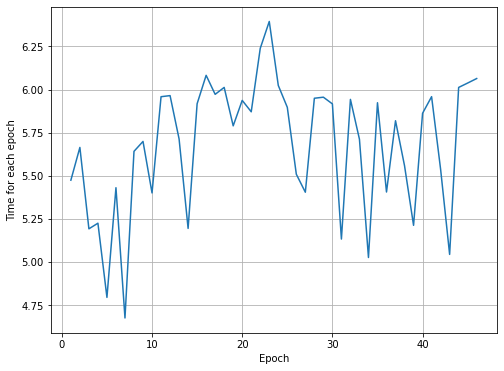

In [10]:
plot_loss(History[0])
plot_time(times[0])

### With learning rate 1e-4

The total training time is 604.8 seconds.


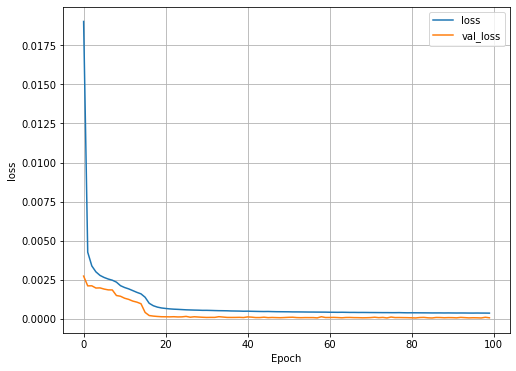

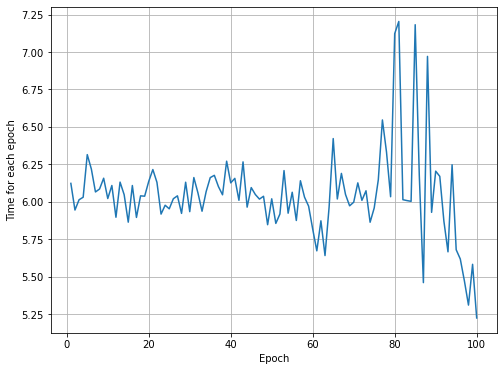

In [11]:
plot_loss(History[1])
plot_time(times[1])

### With learning rate 1e-5

The total training time is 545.3 seconds.


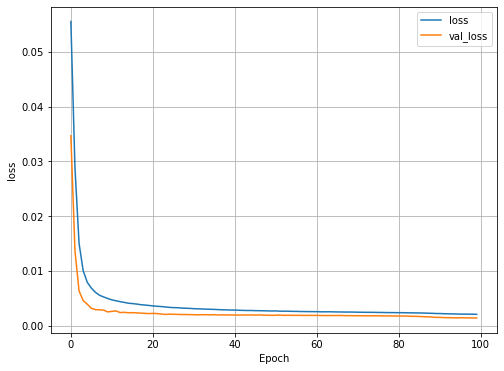

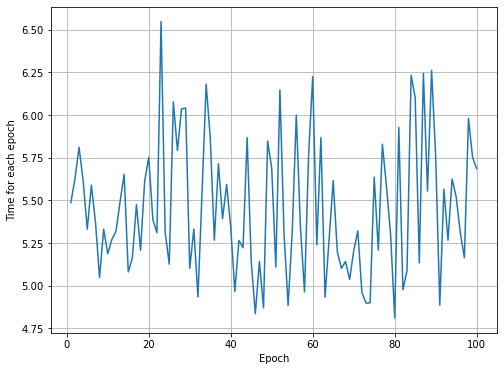

In [12]:
plot_loss(History[2])
plot_time(times[2])